In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten

In [2]:
# Load your stock price data (assumed 'Date' as index and 'Close' as target)
data = pd.read_csv(r'D:\CurrentWork\NvidiaStockPrediction\nvidia_stock_prices.csv', index_col='Date', parse_dates=True)

In [3]:
# Step 1: Data Preprocessing
# Sort the data by date in case it's not sorted
data.sort_index(ascending=True, inplace=True)

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Define a function to create datasets for time series
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time_step (how many past days to consider for prediction)
time_step = 60  # You can adjust this based on your requirement
X, y = create_dataset(scaled_data, time_step)

# Reshape X to fit into Conv1D (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [4]:
# Step 2: Build the CNN Model
model = Sequential()

# First Conv1D layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_step, 1)))
model.add(Dropout(0.1))  # Regularization to prevent overfitting

# Flatten to feed into Dense layers
model.add(Flatten())

# Dense layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))  # Another Dropout layer
model.add(Dense(1))  # Output layer for predicting stock price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [5]:
# Step 3: Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/50
63/63 [==============================] - 3s 5ms/step - loss: 1.0487e-04 - val_loss: 0.0034
Epoch 2/50
63/63 [==============================] - 0s 3ms/step - loss: 2.9961e-05 - val_loss: 0.0015
Epoch 3/50
63/63 [==============================] - 0s 3ms/step - loss: 3.1566e-05 - val_loss: 0.0039
Epoch 4/50
63/63 [==============================] - 0s 3ms/step - loss: 3.5480e-05 - val_loss: 0.0012
Epoch 5/50
63/63 [==============================] - 0s 3ms/step - loss: 2.3198e-05 - val_loss: 0.0041
Epoch 6/50
63/63 [==============================] - 0s 3ms/step - loss: 2.0354e-05 - val_loss: 0.0013
Epoch 7/50
63/63 [==============================] - 0s 3ms/step - loss: 2.2416e-05 - val_loss: 0.0038
Epoch 8/50
63/63 [==============================] - 0s 3ms/step - loss: 1.8830e-05 - val_loss: 0.0013
Epoch 9/50
63/63 [==============================] - 0s 3ms/step - loss: 1.9723e-05 - val_loss: 8.7306e-04
Epoch 10/50
63/63 [==============================] - 0s 3ms/step - loss: 2.072

In [6]:
# Step 4: Evaluate the Model

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions to get actual stock prices
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Inverse transform the actual values to compare
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

32/32 [==============================] - 0s 3ms/step


In [7]:
# Calculate performance metrics
mse = mean_squared_error(y_test_actual, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, test_predictions)
r2 = r2_score(y_test_actual, test_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 1.9579597101402837
Root Mean Squared Error (RMSE): 1.3992711353202008
Mean Absolute Error (MAE): 1.0133344554842056
R-squared (R²): 0.9857122381643261


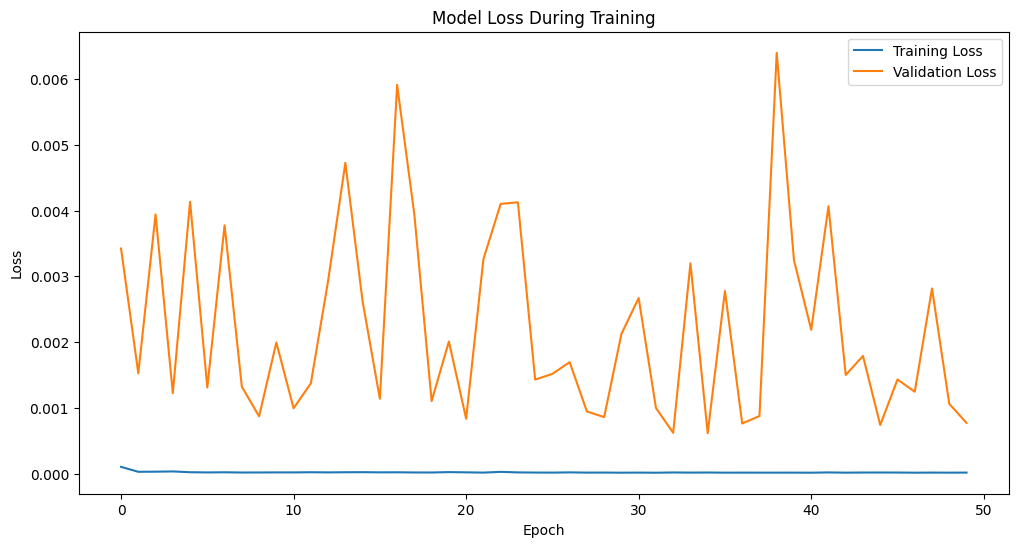

In [8]:
# Step 5: Plot the Results

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

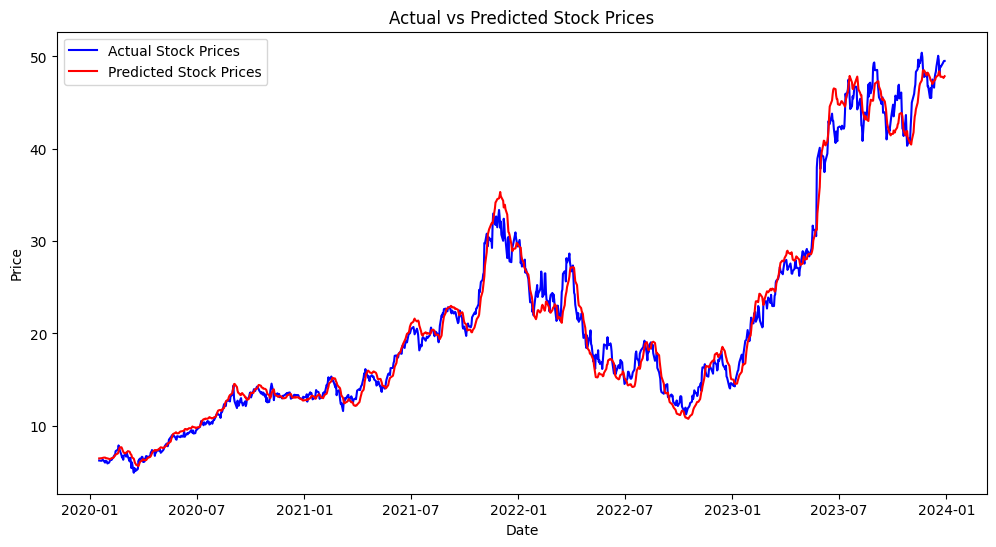

In [9]:
# Plot actual vs predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test_actual):], y_test_actual, color='blue', label='Actual Stock Prices')
plt.plot(data.index[-len(test_predictions):], test_predictions, color='red', label='Predicted Stock Prices')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [10]:
# Save the model
model.save('cnn_stock_prediction_model.h5')